In [1]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
tf.compat.v1.enable_eager_execution()
from tensorflow.keras.layers import Activation, Conv2D, Conv2DTranspose, Dense, Dropout
from tensorflow.keras.layers import Flatten, Input, InputLayer, Reshape, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from alibi.explainers import IntegratedGradients
from alibi.explainers.integrated_gradients import _gradients_input
import matplotlib.pyplot as plt
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from alibi.datasets import fetch_imagenet
from sklearn.datasets import load_iris, load_diabetes
from functools import reduce
%matplotlib inline

In [2]:
from alibi.utils.approximation_methods import approximation_parameters
from alibi.confidence.model_linearity import LinearityMeasure, linearity_measure

In [3]:
%set_env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [4]:
tf.test.is_gpu_available()

True

In [5]:
def alpha_rand(x, tot_feats, alpha, permute=True):
    if permute:
        mask = np.random.permutation(np.concatenate((np.zeros(tot_feats - alpha), np.ones(alpha)))).reshape(x.shape)
    else:
        mask = np.concatenate((np.zeros(tot_feats - alpha), np.ones(alpha))).reshape(x.shape)
    return mask

In [6]:
def plot_saturation_curve(x, label, nb_steps, model, baselines = None, eps=0.0001,
                          batch_size=1000, how='interpolation', permute=True, plot_df=False, agg='global'):

    predict_fn = lambda x: model(tf.dtypes.cast(x, model.input.dtype)).numpy()
    
    nb_samples = x.shape[0]
    step_sizes_func, alphas_func = approximation_parameters('gausslegendre')
    step_sizes, alphas = step_sizes_func(nb_steps), alphas_func(nb_steps)  
    alphas = [0] + alphas + [1]
    nb_steps += 2
    reshape_as = (nb_steps, nb_samples) 
    
    if how == 'interpolation':
        paths = np.concatenate([baselines + alphas[i] * (x - baselines) for i in range(nb_steps)], axis=0)
    elif how == 'random_feats':
        tot_feats = reduce(lambda x, y: x * y, list(x.shape))
        paths = np.concatenate([baselines + alpha_rand(x, tot_feats, int(alphas[i] * tot_feats), permute=permute) * (x - baselines) for i in range(nb_steps)], axis=0)
    target_paths = np.concatenate([label for _ in range(nb_steps)], axis=0)

    lm = LinearityMeasure(nb_samples=10, epsilon=eps, agg=agg)
    lm.fit(paths)
    pred_list, lin_list, grads_list = [], [], []
    nb_batches = np.ceil(len(paths) / batch_size).astype(int)
    for b in range(nb_batches):
        batch = paths[b * batch_size: (b + 1) * batch_size]
        batch_targets = target_paths[b * batch_size: (b + 1) * batch_size]
        probas = model(tf.dtypes.cast(batch, model.input.dtype)).numpy()
        pred = np.diag(probas[:, target_paths])
        pred_list.append(pred)
        # TODO calculate linearity
        lins = lm.score(predict_fn, batch)
        #lins = np.zeros(pred.shape)
        lin_list.append(lins)
        grads = _gradients_input(model, tf.dtypes.cast(batch, model.input.dtype),tf.convert_to_tensor(batch_targets))
        grads = np.abs(grads.numpy().reshape(grads.shape[0], -1)).sum(axis=1)
        grads_list.append(grads)
        if b % 50 == 0:
            print('Batch {} of {} processed'.format(b, nb_batches))
    paths_preds = np.concatenate(pred_list, axis=0).reshape(reshape_as)
    paths_lins = np.concatenate(lin_list, axis=0).reshape(reshape_as)
    paths_grads = np.concatenate(grads_list, axis=0).reshape(reshape_as)
    print(paths_grads.shape)
    
    df_preds = pd.DataFrame(paths_preds, columns=['proba_{}'.format(i) for i in range(nb_samples)])
    df_preds['alphas'] = np.asarray(alphas) / np.asarray(alphas).max()
    df_preds.set_index('alphas', inplace=True)
    
    df_lin = pd.DataFrame(paths_lins, columns=['linearity_{}'.format(i) for i in range(nb_samples)])
    df_lin['alphas'] = np.asarray(alphas) / np.asarray(alphas).max()
    df_lin.set_index('alphas', inplace=True)    
    
    df_grads = pd.DataFrame(paths_grads, columns=['gradients_abssum_{}'.format(i) for i in range(nb_samples)])
    df_grads['alphas'] = np.asarray(alphas) / np.asarray(alphas).max()
    df_grads.set_index('alphas', inplace=True) 
    if plot_df:
        df_preds.plot()
    
    return df_preds, df_lin, df_grads, paths

In [7]:
def define_model(X_train, model_arch, ff_activation='relu', nb_classes=3):
    inputs = Input(shape=(X_train.shape[1:]), dtype=tf.float64)
    if model_arch == 'conv':
        x = Conv2D(64, 2, padding='same', activation='relu', name='conv1')(inputs)
        x = MaxPooling2D(pool_size=(2,2), name='maxpool1')(x)
        x = Dropout(.3)(x)
        x = Conv2D(32, 2, padding='same', activation='relu', name='conv2')(x)
        x = MaxPooling2D(pool_size=(2, 2), name='maxpool2')(x)
        x = Dropout(.3)(x)
        x = Flatten(data_format='channels_last')(x)
        x = Dense(256, activation='relu', name='linear1')(x)
        x = Dropout(.5)(x)
        logits = Dense(nb_classes, name='linear2')(x)
        
    elif model_arch == 'ff':
        x = Dense(256, activation=ff_activation, name='linear1')(inputs)
        logits = Dense(nb_classes, name='linear2')(x)

    outputs = Activation('softmax', name='softmax')(logits)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return model

In [8]:
def alpha_distribution(df, tr=0.5):
    alpha_50 = []
    for col in df.columns:
        df_plus = df[df[col] > tr]
        df_plus.sort_values('alphas', inplace=True)
        try:
            alpha = df_plus.iloc[0].name
        except IndexError:
            alpha = 1
        alpha_50.append(alpha)
    pd.Series(alpha_50).hist(bins=10)
    return alpha_50

In [9]:
model_arch = 'conv'
load_tf_model = True

# Mnist

In [58]:
train, test = tf.keras.datasets.mnist.load_data()
X_train, labels_train = train
X_test, labels_test = test
if model_arch == 'conv':
    X_train = X_train.reshape(-1, 28, 28, 1).astype('float64') / 255
    X_test = X_test.reshape(-1, 28, 28, 1).astype('float64') / 255
    y_train = to_categorical(labels_train, 10)
    y_test = to_categorical(labels_test, 10)
elif model_arch == 'ff':
    X_train = X_train.reshape(-1, 28 * 28).astype('float64') / 255
    X_test = X_test.reshape(-1, 28 * 28).astype('float64') / 255
    y_train = to_categorical(labels_train, 10)
    y_test = to_categorical(labels_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28, 1) (60000, 10) (10000, 28, 28, 1) (10000, 10)


In [59]:
filepath = './model_{}_mnist/'.format(model_arch)#change to directory where model is downloaded

if load_tf_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
else:
    # define model
    model = define_model(X_train, model_arch, nb_classes=10)
    # train model
    model.fit(X_train,
              y_train,
              epochs=10,
              batch_size=256,
              verbose=2,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
    #model.save_weights(os.path.join(filepath, 'model.ckpt'))

In [64]:
i = 11
n_samples = 100
x = X_test[i: i + n_samples]
label = labels_test[i: i + n_samples]
#label

In [65]:
baselines = np.zeros(x.shape)

In [66]:
df_inter_preds, df_inter_lins, df_inter_grads, paths = plot_saturation_curve(x, label, 50, model, eps=0.0001, 
                                                                             batch_size=5, 
                                                             baselines = baselines,
                                                             how='interpolation', plot_df=False, agg='global')

NotFoundError: Could not find valid device for node.
Node:{{node GatherV2}}
All kernels registered for op GatherV2 :
  device='XLA_GPU'; Taxis in [DT_INT32, DT_INT64]; Tparams in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT8, ..., DT_BFLOAT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]; Tindices in [DT_INT32, DT_INT64]
  device='XLA_CPU'; Taxis in [DT_INT32, DT_INT64]; Tparams in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT8, ..., DT_BFLOAT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]; Tindices in [DT_INT32, DT_INT64]
  device='XLA_CPU_JIT'; Taxis in [DT_INT32, DT_INT64]; Tparams in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT8, ..., DT_BFLOAT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]; Tindices in [DT_INT32, DT_INT64]
  device='XLA_GPU_JIT'; Taxis in [DT_INT32, DT_INT64]; Tparams in [DT_FLOAT, DT_DOUBLE, DT_INT32, DT_UINT8, DT_INT8, ..., DT_BFLOAT16, DT_COMPLEX128, DT_HALF, DT_UINT32, DT_UINT64]; Tindices in [DT_INT32, DT_INT64]
  device='GPU'; Tparams in [DT_COMPLEX128]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_COMPLEX128]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_COMPLEX64]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_COMPLEX64]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_DOUBLE]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_DOUBLE]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_FLOAT]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_FLOAT]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_HALF]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_HALF]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_INT64]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_INT64]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_INT32]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_INT32]; Tindices in [DT_INT32]
  device='GPU'; Tparams in [DT_BOOL]; Tindices in [DT_INT64]
  device='GPU'; Tparams in [DT_BOOL]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_UINT64]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_UINT64]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_UINT32]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_UINT32]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QINT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QINT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QUINT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QUINT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QINT32]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QINT32]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QUINT8]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QUINT8]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_QINT8]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_QINT8]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_VARIANT]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_VARIANT]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_RESOURCE]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_RESOURCE]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_STRING]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_STRING]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_BOOL]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_BOOL]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_COMPLEX128]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_COMPLEX128]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_COMPLEX64]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_COMPLEX64]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_DOUBLE]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_DOUBLE]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_FLOAT]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_FLOAT]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_BFLOAT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_BFLOAT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_HALF]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_HALF]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_INT8]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_INT8]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_UINT8]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_UINT8]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_INT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_INT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_UINT16]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_UINT16]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_INT32]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_INT32]; Tindices in [DT_INT32]
  device='CPU'; Tparams in [DT_INT64]; Tindices in [DT_INT64]
  device='CPU'; Tparams in [DT_INT64]; Tindices in [DT_INT32]
 [Op:GatherV2]

In [ ]:
#df_inter_grads.plot()

In [164]:
df_perm_preds, df_perm_lins, df_inter_grads, paths = plot_saturation_curve(x, label, 50, model, 
                                                                           batch_size=1, baselines = baselines,
                                                           how='random_feats',plot_df=False)

(52, 50)


In [165]:
#df_perm_lins.plot()

In [166]:
df_noperm_preds, df_noperm_lins, df_inter_grads, paths = plot_saturation_curve(x, label, 50, model, batch_size=1, baselines = baselines,
                                                               how='random_feats', permute=False, plot_df=False)

(52, 50)



A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


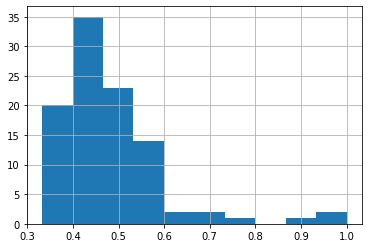

In [129]:
alphas_inter_preds = alpha_distribution(df_inter_preds, tr=0.8)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


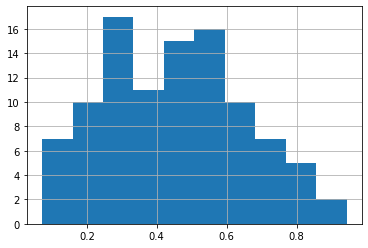

In [130]:
alphas_perm_preds = alpha_distribution(df_perm_preds, tr =0.8)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


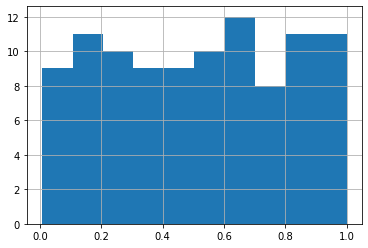

In [131]:
alphas_perm_preds = alpha_distribution(df_noperm_preds, tr =0.8)

## Linearity

In [48]:
for col in df_inter_lins.columns:
    df_inter_lins[col] = df_inter_lins[col] / df_inter_lins[col].max()
for col in df_inter_grads.columns:
    df_inter_grads[col] = df_inter_grads[col] / df_inter_grads[col].max()
df_inter_merged = pd.merge(df_inter_lins, df_inter_preds, right_index=True, left_index=True)
df_inter_merged = pd.merge(df_inter_merged, df_inter_grads, right_index=True, left_index=True)
df_inter_merged.reset_index(inplace=True)

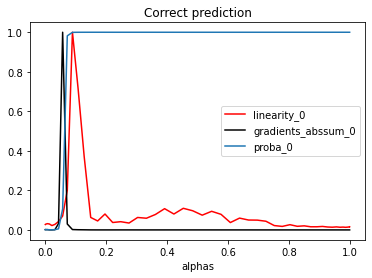

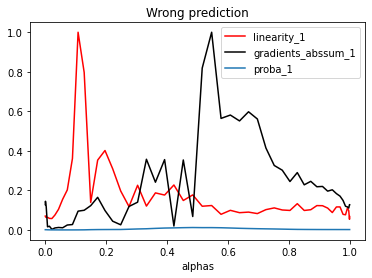

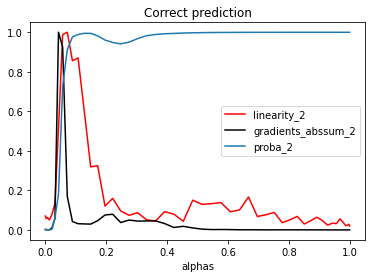

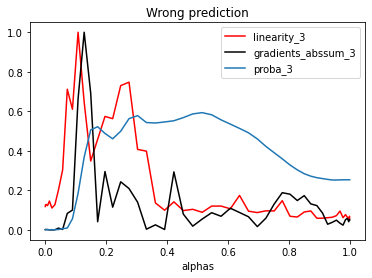

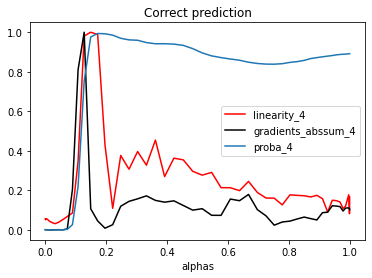

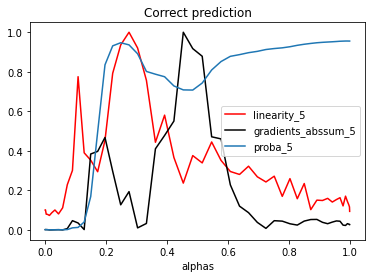

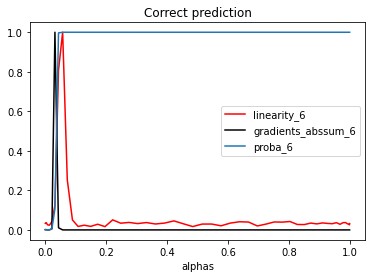

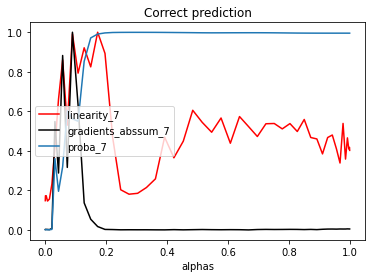

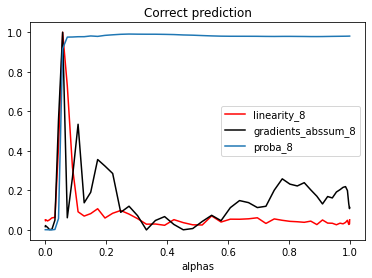

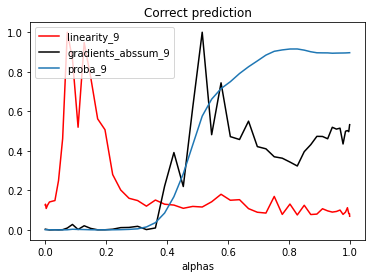

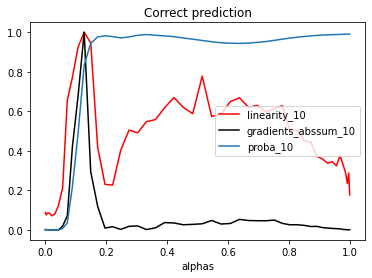

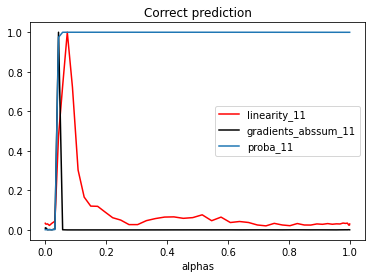

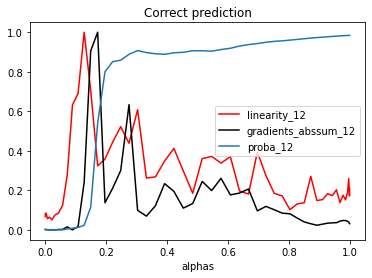

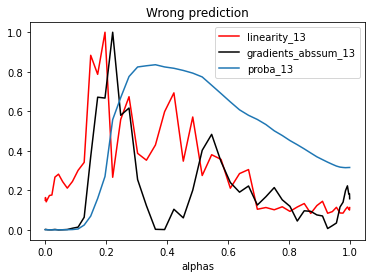

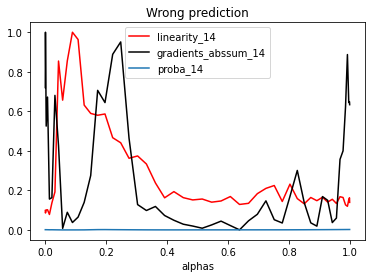

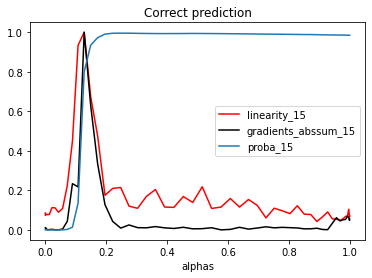

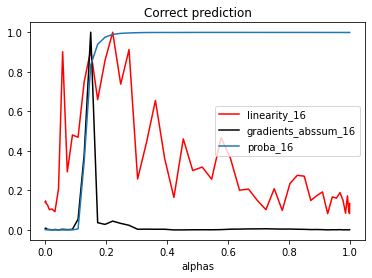

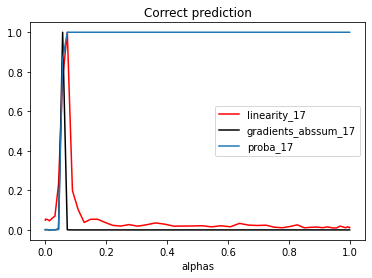

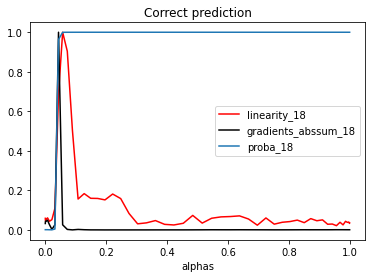

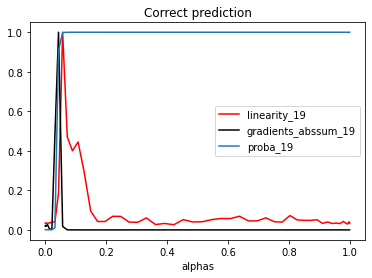

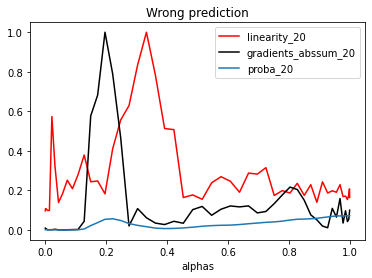

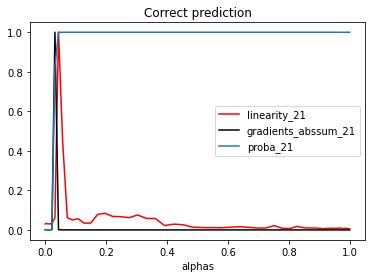

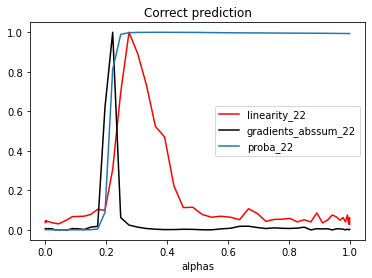

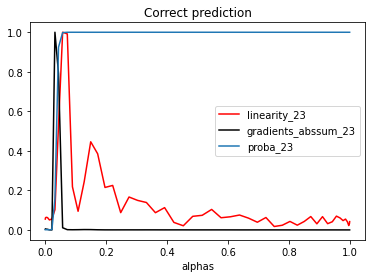

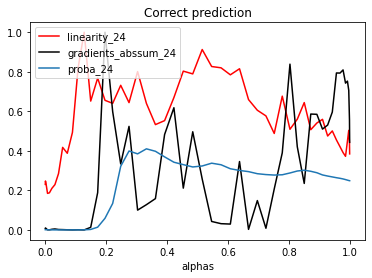

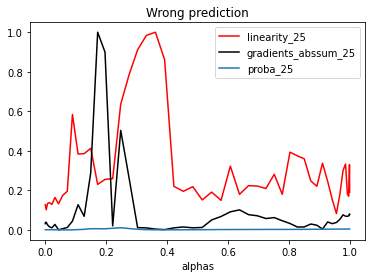

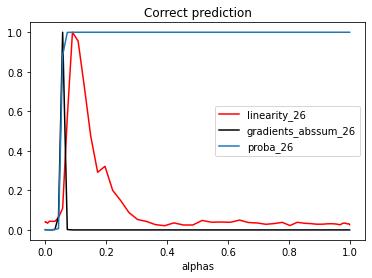

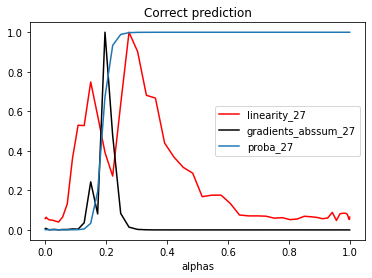

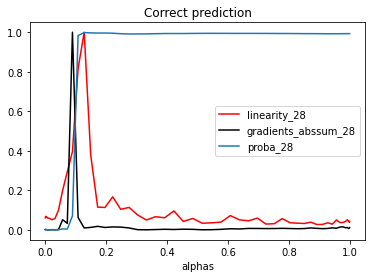

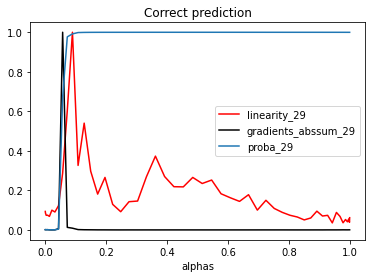

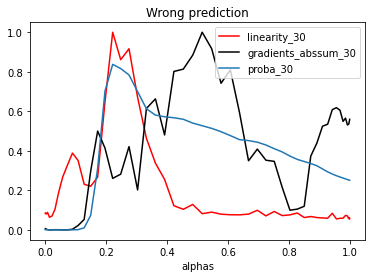

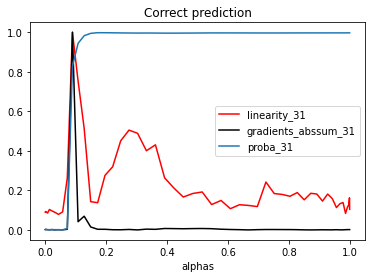

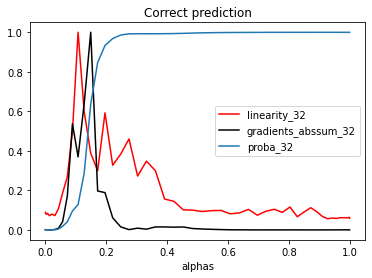

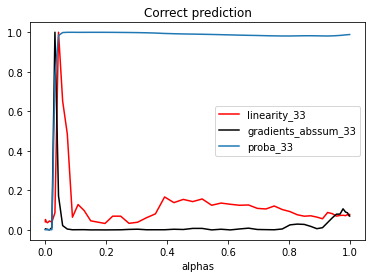

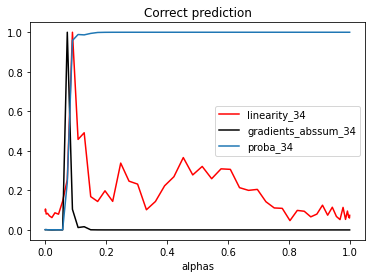

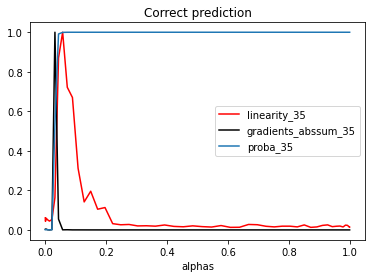

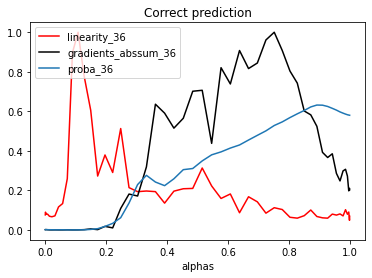

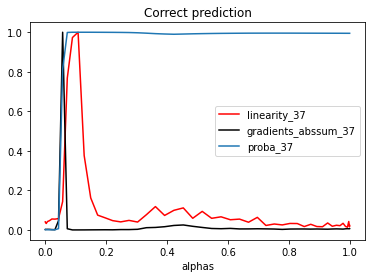

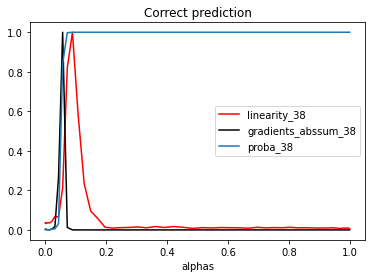

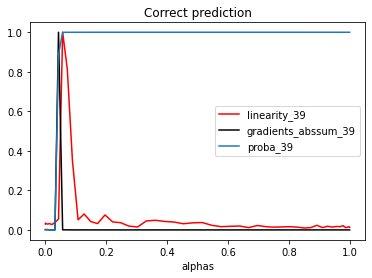

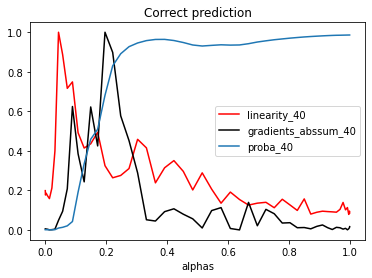

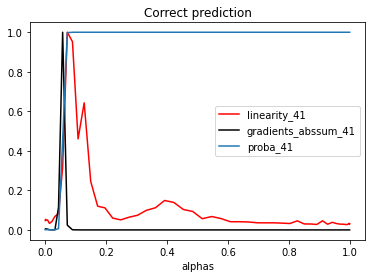

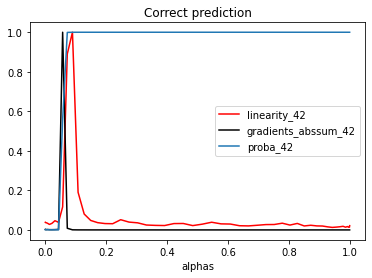

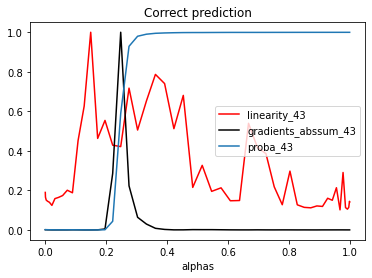

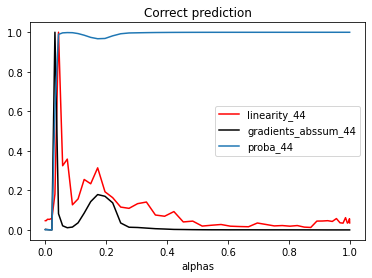

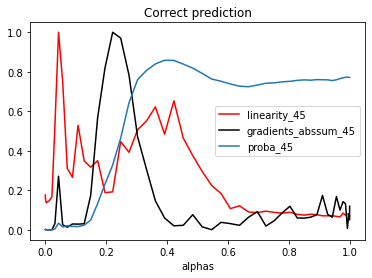

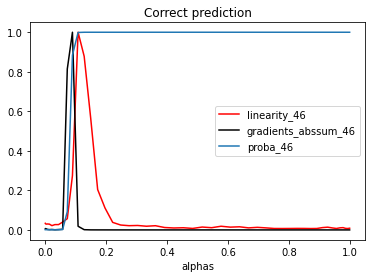

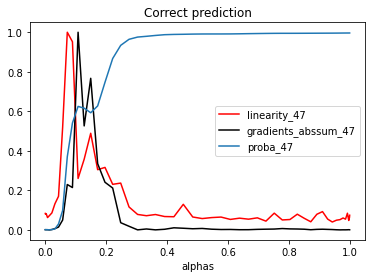

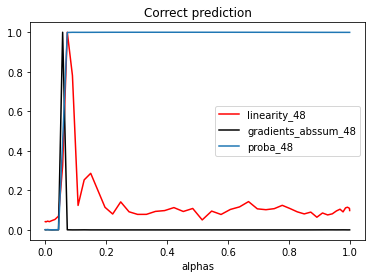

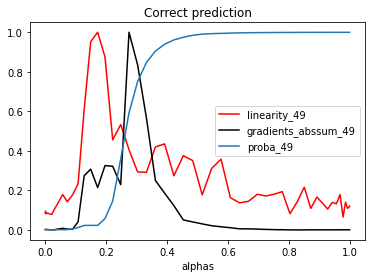

In [49]:
for i in range(50):
    if np.argmax(model(tf.dtypes.cast(x[i:i+1], model.input.dtype)).numpy()) == 283:
        title = 'Correct prediction'
    else:
        title = 'Wrong prediction'
    ax = df_inter_merged.plot(x='alphas', y='linearity_{}'.format(i), color='red')
    df_inter_merged.plot(x='alphas', y='gradients_abssum_{}'.format(i), ax=ax, color='black')
    df_inter_merged.plot(x='alphas', y='proba_{}'.format(i), ax=ax, title= title)

    plt.show()

In [22]:
df_inter_merged = pd.merge(df_inter_lins, df_inter_preds, right_index=True, left_index=True)

In [23]:
df_inter_merged.columns

Index(['linearity_0', 'linearity_1', 'linearity_2', 'linearity_3',
       'linearity_4', 'linearity_5', 'linearity_6', 'linearity_7',
       'linearity_8', 'linearity_9',
       ...
       'proba_90', 'proba_91', 'proba_92', 'proba_93', 'proba_94', 'proba_95',
       'proba_96', 'proba_97', 'proba_98', 'proba_99'],
      dtype='object', length=200)

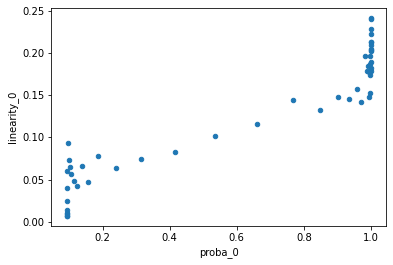

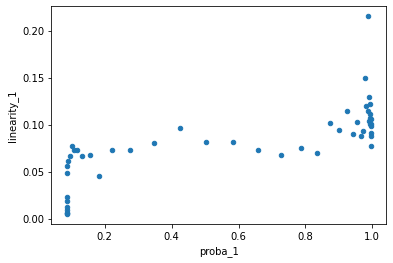

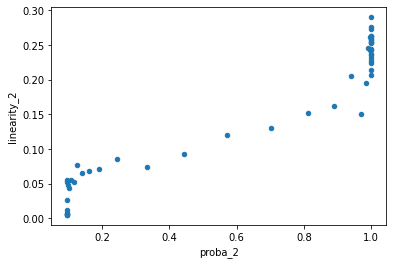

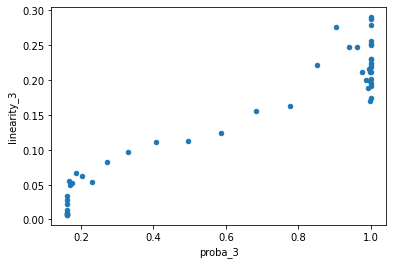

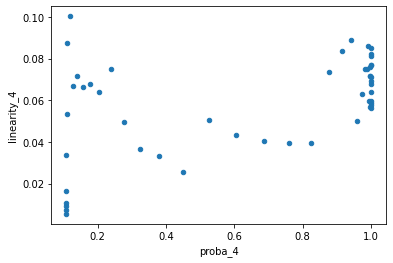

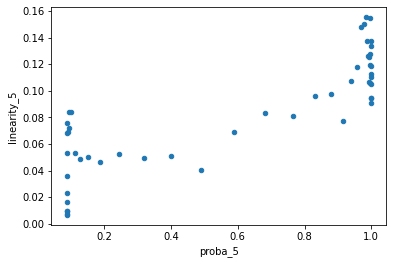

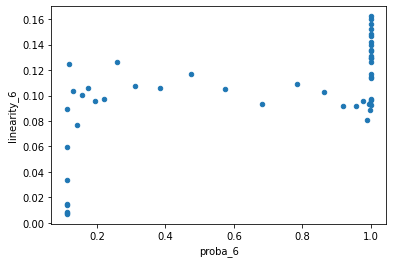

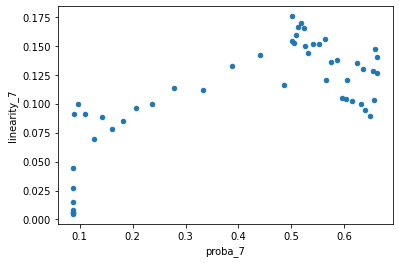

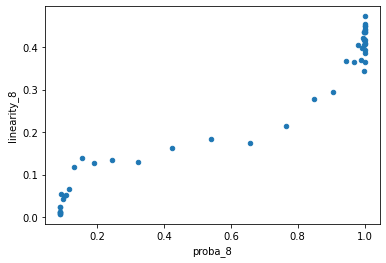

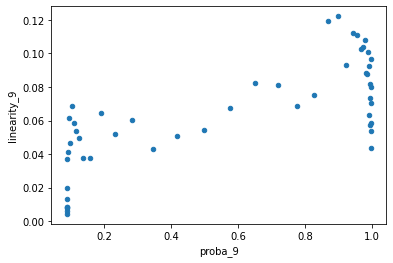

In [27]:
for i in range(10):
    df_inter_merged[['linearity_{}'.format(i), 'proba_{}'.format(i)]].plot(x='proba_{}'.format(i), 
                                                                           y='linearity_{}'.format(i),
                                                                          kind='scatter')
    plt.show()

In [29]:
df_perm_merged = pd.merge(df_perm_lins, df_perm_preds, right_index=True, left_index=True)

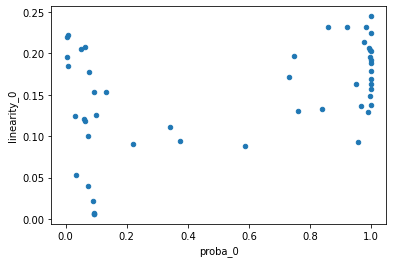

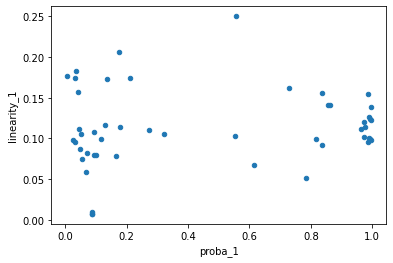

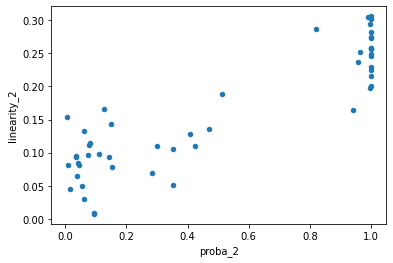

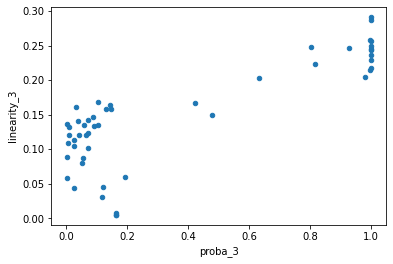

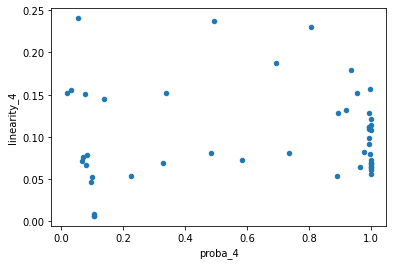

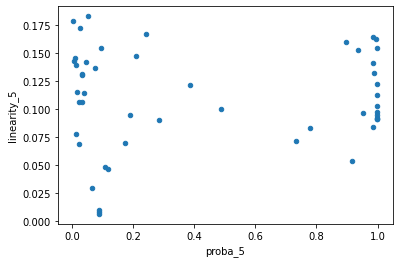

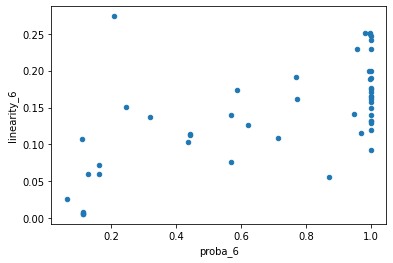

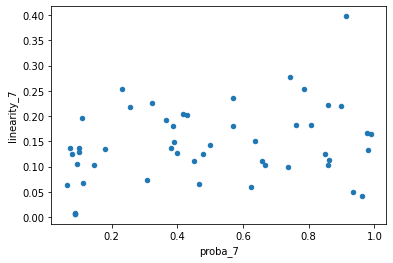

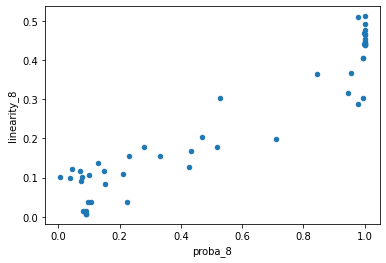

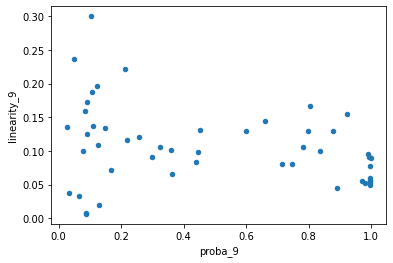

In [30]:
for i in range(10):
    df_perm_merged[['linearity_{}'.format(i), 'proba_{}'.format(i)]].plot(x='proba_{}'.format(i), 
                                                                          y='linearity_{}'.format(i),
                                                                         kind='scatter')
    plt.show()

# Cifar

In [22]:
train, test = tf.keras.datasets.cifar10.load_data()
X_train, labels_train = train
X_test, labels_test = test
labels_train, labels_test = labels_train.flatten(), labels_test.flatten()
if model_arch == 'conv':
    X_train = X_train.reshape(-1, 32, 32, 3).astype('float64') / 255
    X_test = X_test.reshape(-1, 32, 32, 3).astype('float64') / 255
    y_train = to_categorical(labels_train, 10)
    y_test = to_categorical(labels_test, 10)
elif model_arch == 'ff':
    X_train = X_train.reshape(-1, 32 * 32 * 3).astype('float64') / 255
    X_test = X_test.reshape(-1, 32 * 32 * 3).astype('float64') / 255
    y_train = to_categorical(labels_train, 10)
    y_test = to_categorical(labels_test, 10)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(50000, 32, 32, 3) (50000, 10) (10000, 32, 32, 3) (10000, 10)


In [23]:
model_arch = 'conv'
load_tf_model = True

In [24]:
filepath = './model_{}_cifar/'.format(model_arch)#change to directory where model is downloaded

if load_tf_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
else:
    # define model
    model = define_model(X_train, model_arch, nb_classes=10)
    # train model
    model.fit(X_train,
              y_train,
              epochs=10,
              batch_size=256,
              verbose=2,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
    #model.save_weights(os.path.join(filepath, 'model.ckpt'))

In [25]:
i = 11
n_samples = 100
x = X_test[i: i + n_samples]
label = labels_test[i: i + n_samples]
#label

In [26]:
df_inter_preds, df_inter_lins, paths = plot_saturation_curve(x, label, 50, model, eps=0.0001, batch_size=500,
                                                             how='interpolation', plot_df=False, agg='global')

(50, 100)


In [27]:
#df_inter_lins.plot()

In [28]:
df_perm_preds, df_perm_lins, paths = plot_saturation_curve(x, label, 50, model, batch_size=500, how='random_feats',plot_df=False)

(50, 100)


In [29]:
#df_perm_lins.plot()

In [30]:
df_noperm_preds, df_noperm_lins, paths = plot_saturation_curve(x, label, 50, model,  batch_size=500,
                                                               how='random_feats', permute=False, plot_df=False)

(50, 100)


In [31]:
#df_noperm_lins.plot()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


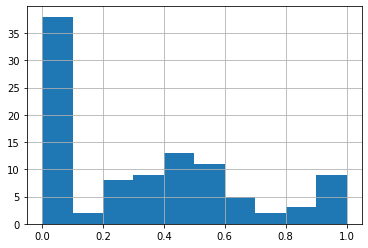

In [32]:
alphas_inter_preds = alpha_distribution(df_inter_preds, tr=0.2)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


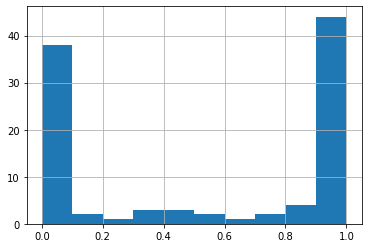

In [33]:
alphas_perm_preds = alpha_distribution(df_perm_preds, tr =0.2)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


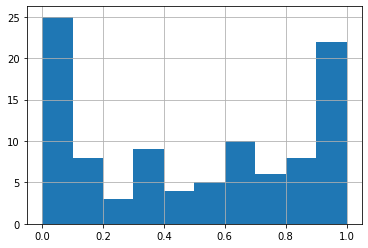

In [34]:
alphas_noperm_preds = alpha_distribution(df_noperm_preds, tr =0.2)

# Resnet imagenet

In [10]:
category = 'Persian cat'
image_shape = (224, 224, 3)
data, labels = fetch_imagenet(category, nb_images=50, target_size=image_shape[:2], seed=2, return_X_y=True)
data = data / 255
print('Images shape: {}'.format(data.shape))

Images shape: (50, 224, 224, 3)


In [11]:
model = ResNet50V2(weights='imagenet')

In [12]:
i = 0
nb_samples =100
x = data[i: i + nb_samples]
label = labels[i: i + nb_samples]
label

array([283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283,
       283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283,
       283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283,
       283, 283, 283, 283, 283, 283, 283, 283, 283, 283, 283])

In [13]:
#model.summary()

In [14]:
baselines = np.zeros(x.shape)

In [15]:
df_inter_preds, df_inter_lins, df_inter_grads, paths = plot_saturation_curve(x, label, 50, model, eps=0.0001, 
                                                                             batch_size=5, 
                                                             baselines = baselines,
                                                             how='interpolation', plot_df=False, agg='global')

Batch 0 of 520 processed
Batch 50 of 520 processed
Batch 100 of 520 processed
Batch 150 of 520 processed
Batch 200 of 520 processed
Batch 250 of 520 processed
Batch 300 of 520 processed
Batch 350 of 520 processed
Batch 400 of 520 processed
Batch 450 of 520 processed
Batch 500 of 520 processed
(52, 50)


In [ ]:
#df_inter_grads.plot()

In [164]:
df_perm_preds, df_perm_lins, df_inter_grads, paths = plot_saturation_curve(x, label, 50, model, 
                                                                           batch_size=1, baselines = baselines,
                                                           how='random_feats',plot_df=False)

(52, 50)


In [165]:
#df_perm_lins.plot()

In [166]:
df_noperm_preds, df_noperm_lins, df_inter_grads, paths = plot_saturation_curve(x, label, 50, model, batch_size=1, baselines = baselines,
                                                               how='random_feats', permute=False, plot_df=False)

(52, 50)


In [167]:
#df_noperm_lins.plot()


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


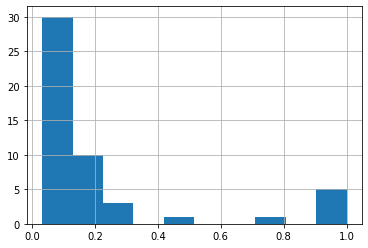

In [173]:
alphas_inter_preds = alpha_distribution(df_inter_preds, tr=0.5)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


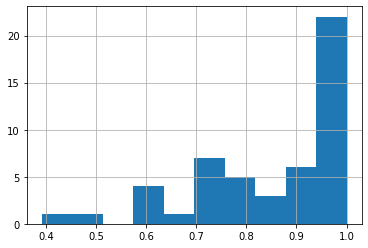

In [174]:
alphas_perm_preds = alpha_distribution(df_perm_preds, tr =0.5)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


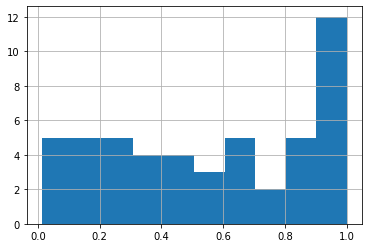

In [175]:
alphas_perm_preds = alpha_distribution(df_noperm_preds, tr =0.5)

## Linearity

In [16]:
for col in df_inter_lins.columns:
    df_inter_lins[col] = df_inter_lins[col] / df_inter_lins[col].max()
for col in df_inter_grads.columns:
    df_inter_grads[col] = df_inter_grads[col] / df_inter_grads[col].max()
df_inter_merged = pd.merge(df_inter_lins, df_inter_preds, right_index=True, left_index=True)
df_inter_merged = pd.merge(df_inter_merged, df_inter_grads, right_index=True, left_index=True)
df_inter_merged.reset_index(inplace=True)

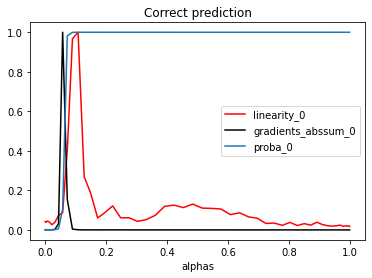

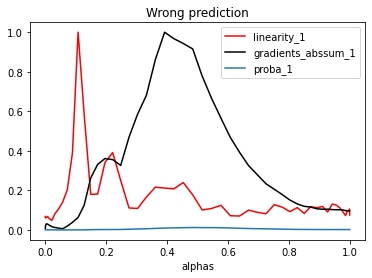

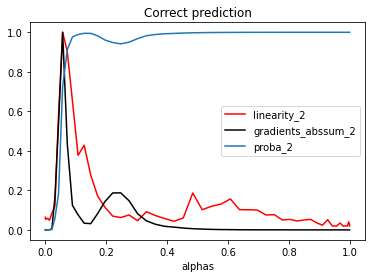

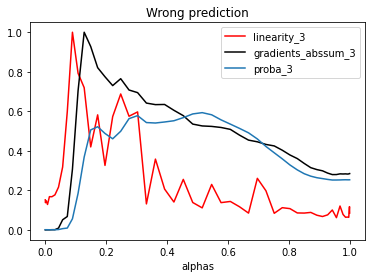

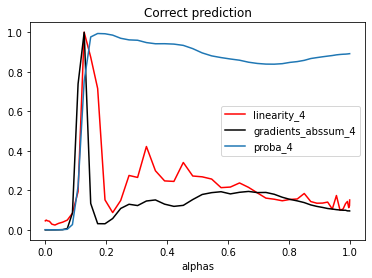

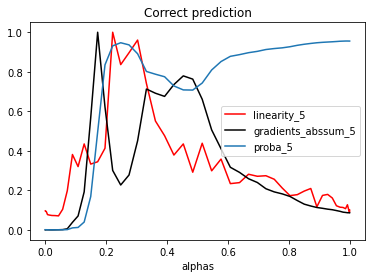

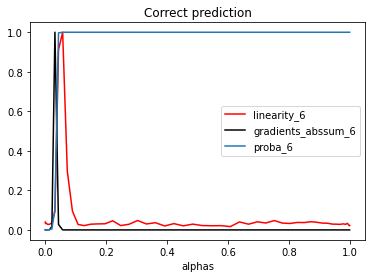

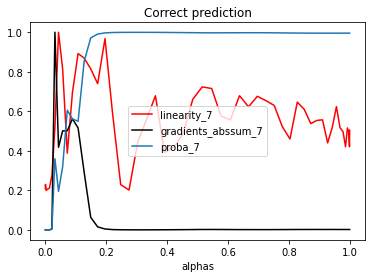

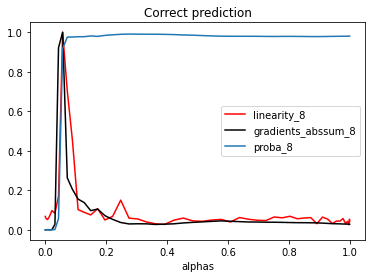

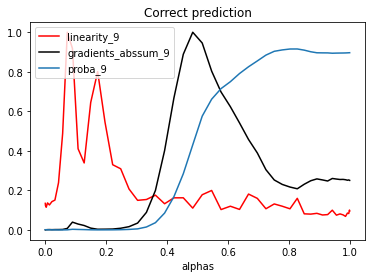

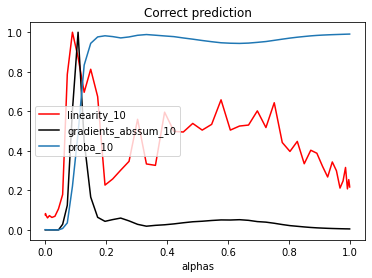

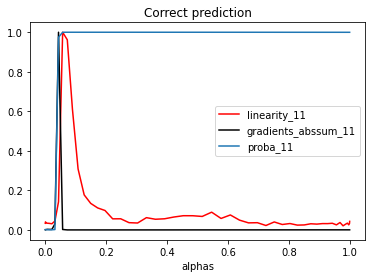

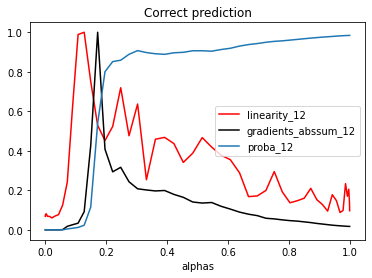

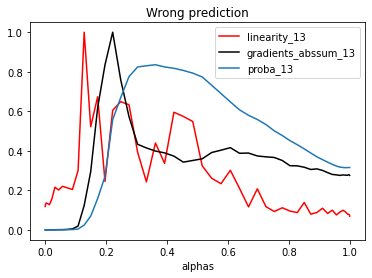

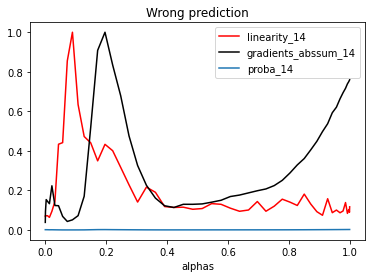

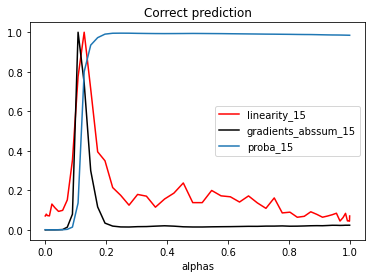

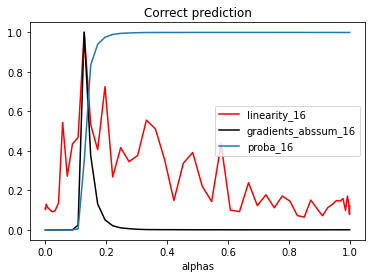

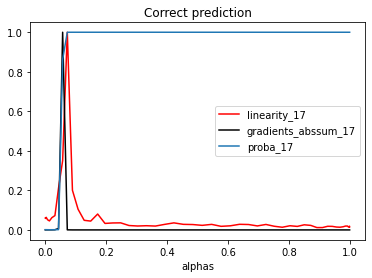

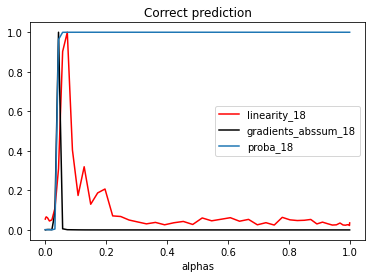

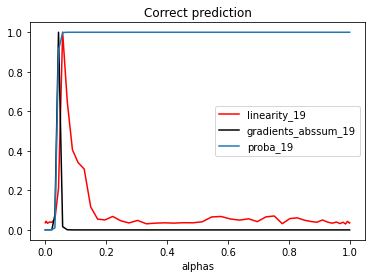

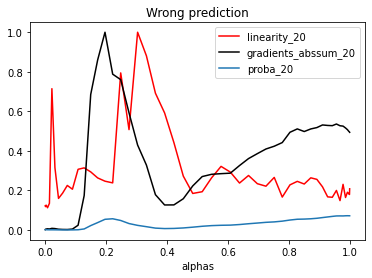

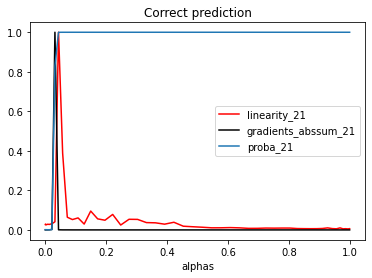

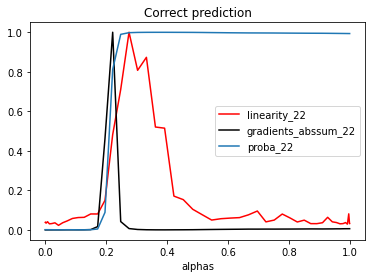

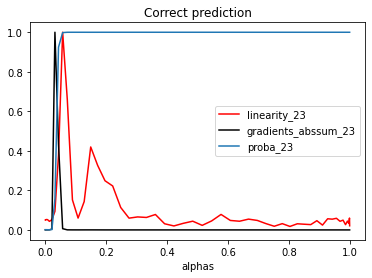

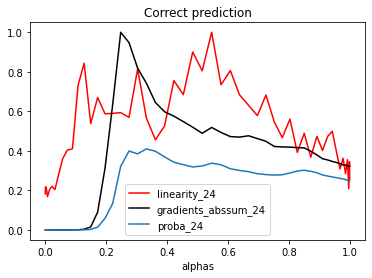

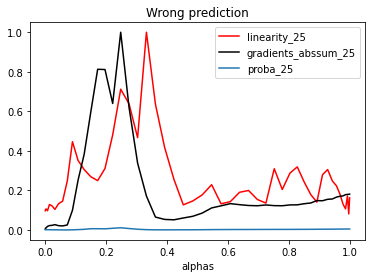

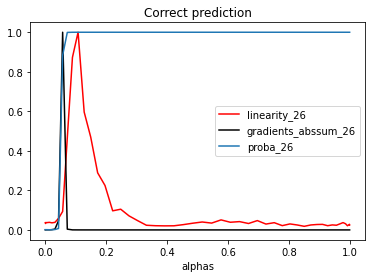

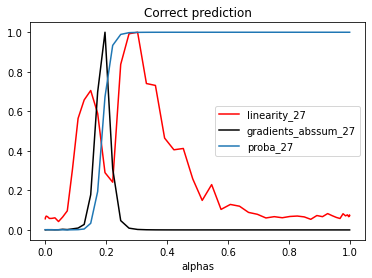

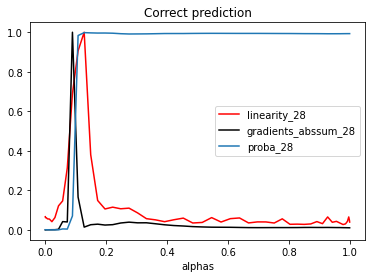

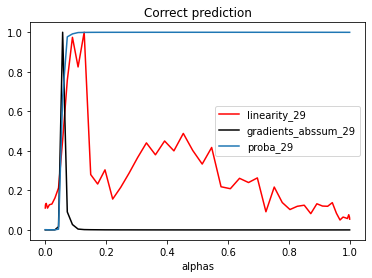

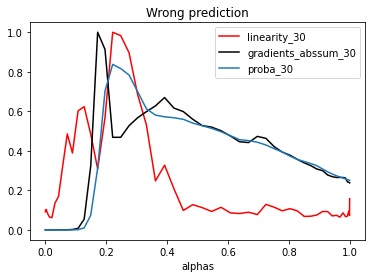

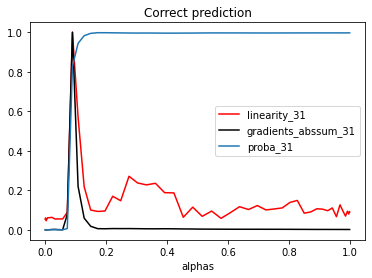

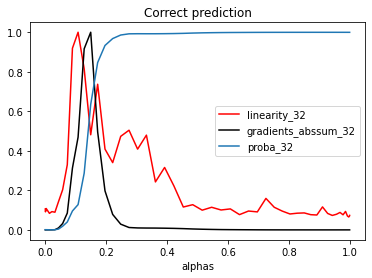

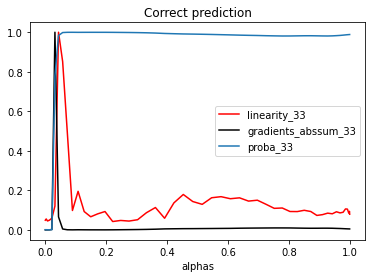

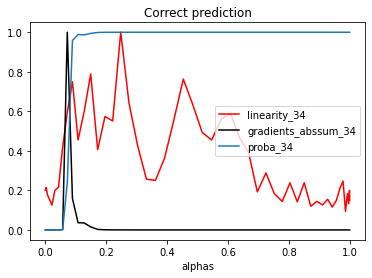

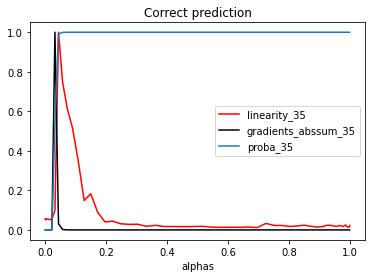

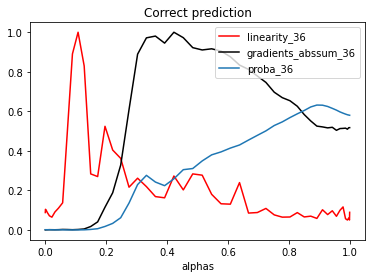

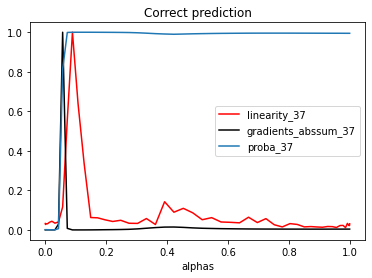

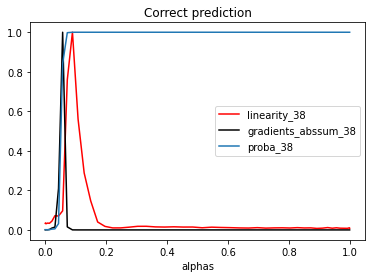

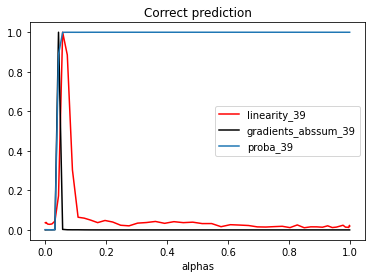

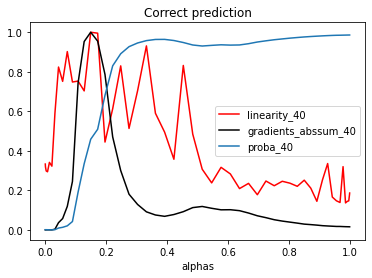

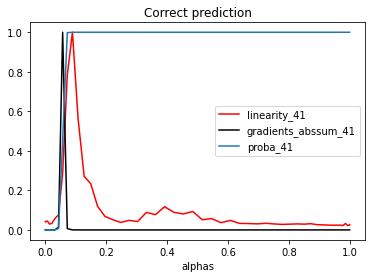

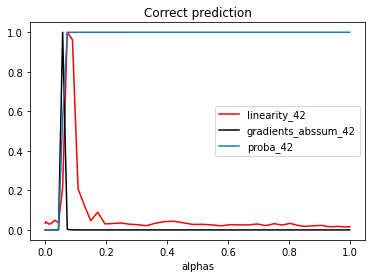

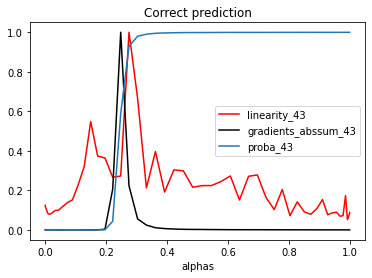

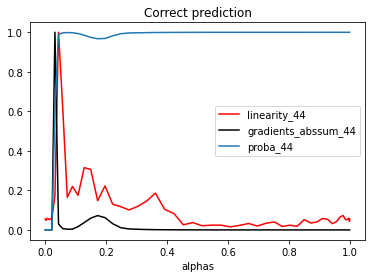

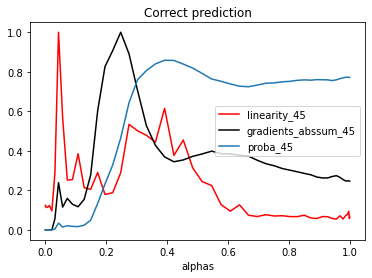

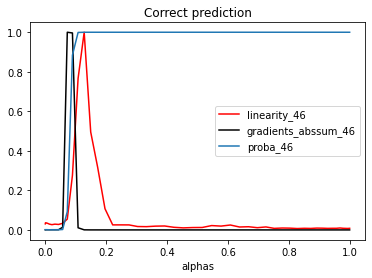

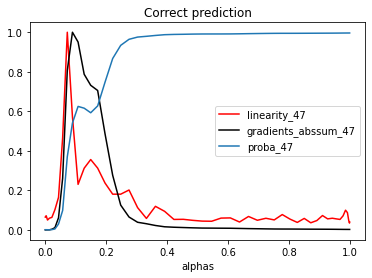

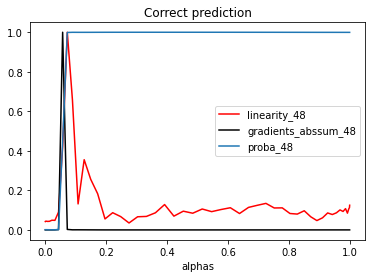

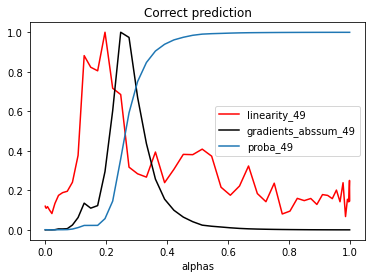

In [17]:
for i in range(50):
    if np.argmax(model(tf.dtypes.cast(x[i:i+1], model.input.dtype)).numpy()) == 283:
        title = 'Correct prediction'
    else:
        title = 'Wrong prediction'
    ax = df_inter_merged.plot(x='alphas', y='linearity_{}'.format(i), color='red')
    df_inter_merged.plot(x='alphas', y='gradients_abssum_{}'.format(i), ax=ax, color='black')
    df_inter_merged.plot(x='alphas', y='proba_{}'.format(i), ax=ax, title= title)

    plt.show()

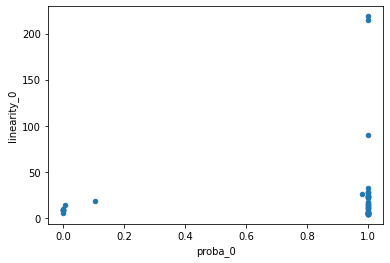

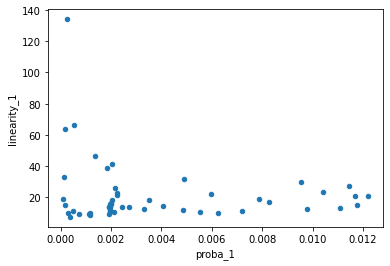

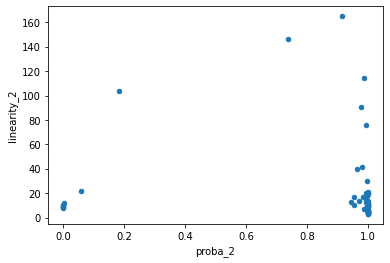

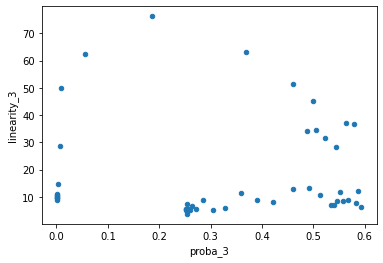

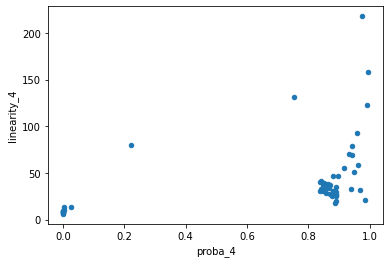

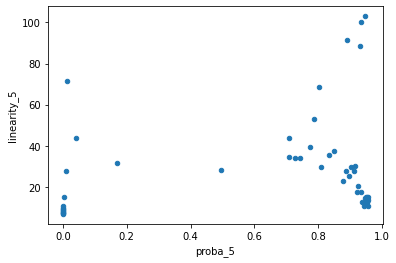

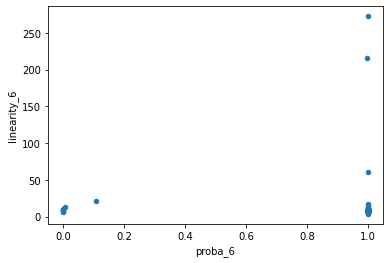

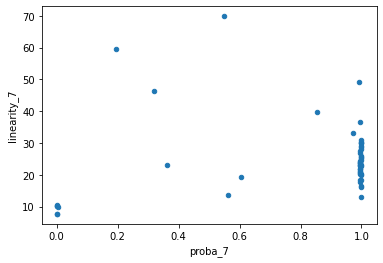

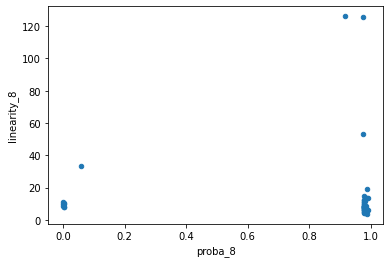

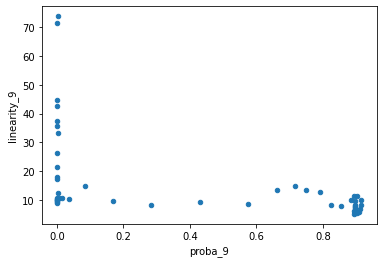

In [92]:
#for i in range(10):
#    df_inter_merged[['linearity_{}'.format(i), 'proba_{}'.format(i), 'alphas']].plot(x='proba_{}'.format(i), 
#                                                                     y='linearity_{}'.format(i),
#                                                                    kind='scatter')
#    plt.show()

In [90]:
df_perm_merged = pd.merge(df_perm_lins, df_perm_preds, right_index=True, left_index=True)
df_perm_merged.reset_index(inplace=True)

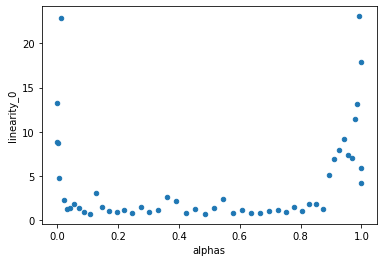

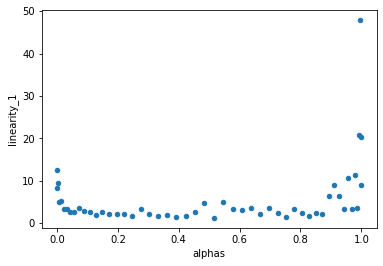

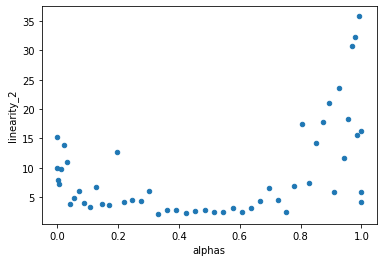

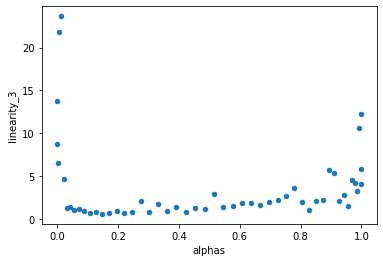

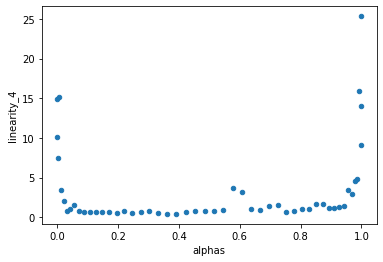

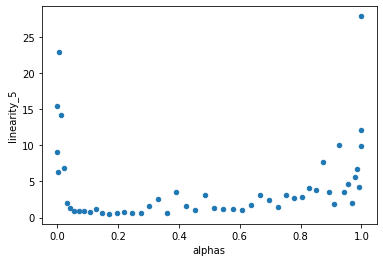

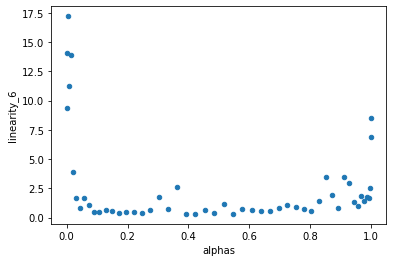

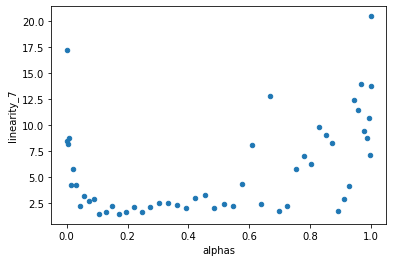

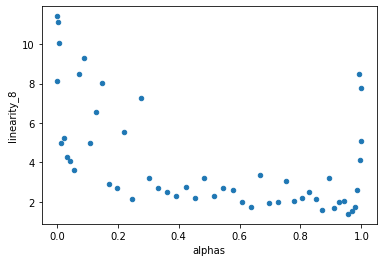

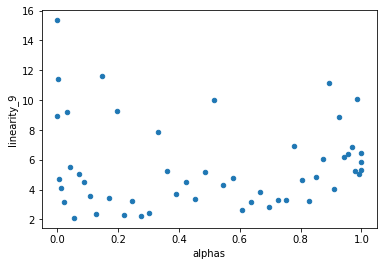

In [91]:
for i in range(10):
    df_perm_merged[['linearity_{}'.format(i), 'proba_{}'.format(i), 'alphas']].plot(x='alphas', 
                                                                     y='linearity_{}'.format(i),
                                                                    kind='scatter')
    plt.show()

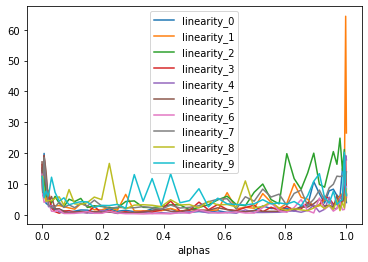

In [47]:
df_perm_lins[['linearity_{}'.format(i) for i in range(10)]].plot()

# Iris

In [126]:
iris = load_iris()

In [127]:
perm = np.random.permutation(range(len(X_iris))).tolist()

In [292]:

X_iris = iris.data
X_iris = X_iris[perm]
labels = iris.target
labels = labels[perm]

y_iris = to_categorical(labels)
X_train, labels_train = X_iris[:int(0.7 * X_iris.shape[0])], labels[:int(0.7 * X_iris.shape[0])]
X_test, labels_test = X_iris[int(0.7 * X_iris.shape[0]):], labels[int(0.7 * X_iris.shape[0]):]
y_train = to_categorical(labels_train, 3)
y_test = to_categorical(labels_test, 3)


In [293]:
labels_train

array([0, 1, 2, 0, 2, 1, 1, 2, 0, 1, 0, 1, 2, 2, 2, 1, 0, 1, 2, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 2, 2, 1, 0, 0, 2, 1, 1, 1, 0, 1, 0, 0, 2, 1, 1,
       1, 2, 2, 0, 1, 2, 0, 2, 1, 2, 0, 2, 1, 1, 0, 2, 0, 0, 1, 2, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 2, 1, 1, 2, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       1, 2, 0, 2, 0, 2, 0, 1, 2, 0, 0, 0, 1, 2, 0, 0, 2])

In [294]:
filepath = './model_iris'#change to directory where model is downloaded

if load_tf_model:
    model = tf.keras.models.load_model(os.path.join(filepath, 'model.h5'))
else:
    # define model
    model = define_model(X_iris, 'ff', ff_activation='relu')
    # train model
    model.fit(X_train,
              y_train,
              epochs=100,
              batch_size=256,
              verbose=1,
              validation_data=(X_test, y_test)
              )
    if not os.path.exists(filepath):
        os.makedirs(filepath)
    model.save(os.path.join(filepath, 'model_{}.h5'.format(model_arch)))
    #model.save_weights(os.path.join(filepath, 'model.ckpt'))

OSError: SavedModel file does not exist at: ./model_iris/model.h5/{saved_model.pbtxt|saved_model.pb}

In [131]:
x = X_test[0].reshape(1, -1)
label = labels_test[0]
x.shape

(1, 4)

(50, 4)


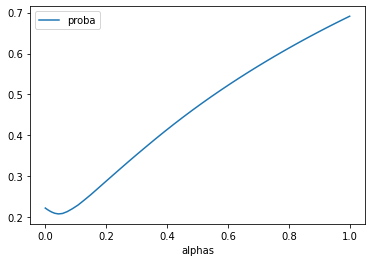

In [132]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='interpolation')

(50, 4)


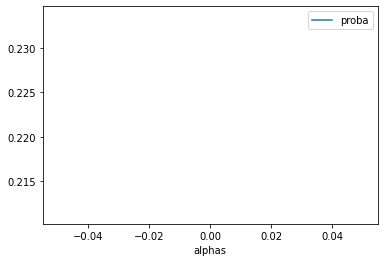

In [133]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='random_feats')

(50, 4)


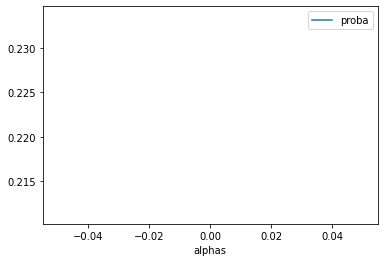

In [134]:
alphas, paths = plot_saturation_curve(x, label, 50, model, how='random_feats', permute=False)

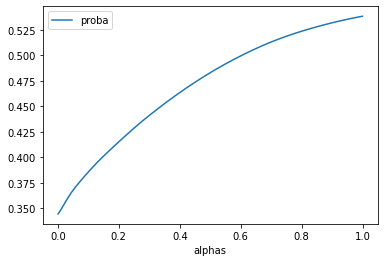

In [102]:
plot_saturation_curve(x, label, model)


In [103]:
model(x)

<tf.Tensor: id=59714, shape=(1, 3), dtype=float64, numpy=array([[0.06966999, 0.53826848, 0.39206153]])>

In [132]:
model_arch ='conv' #  'ff'

In [67]:
class C():
    def __init__(self):
        pass

In [68]:
cc = C()

In [70]:
isinstance(cc, C)

True